In [1]:
import sys
sys.path.append("..")
from damage_indicator_module.damage_indicator_module import*

In [2]:
results_filename = '../0_Back_to_back_IDA_data/all_results_ID1021.h5'

set_plot_formatting()

#### Selected damaging ground motion ####
gm_id = 'GM15'

In [3]:
savefig = True

key = 'ground_motion_records/gm_record_metadata'
gm_metadata = pd.read_hdf(results_filename, key)

key = '/intact_results/ida/collapse_fragilities'
df = pd.read_hdf(results_filename, key)
df = df[df.index.isin(['Sa_avg'])]
df['initial_condition'] = 'Intact'
ida_intact_fragility = df.set_index('initial_condition')

intact_ida_folder = '/intact_results/ida/'
intact_ida_segments = collect_ida_curves(results_filename, gm_metadata, intact_ida_folder)

[peak_segments, residual_segments] = collect_peak_and_residual_drift_curves(results_filename, gm_metadata)


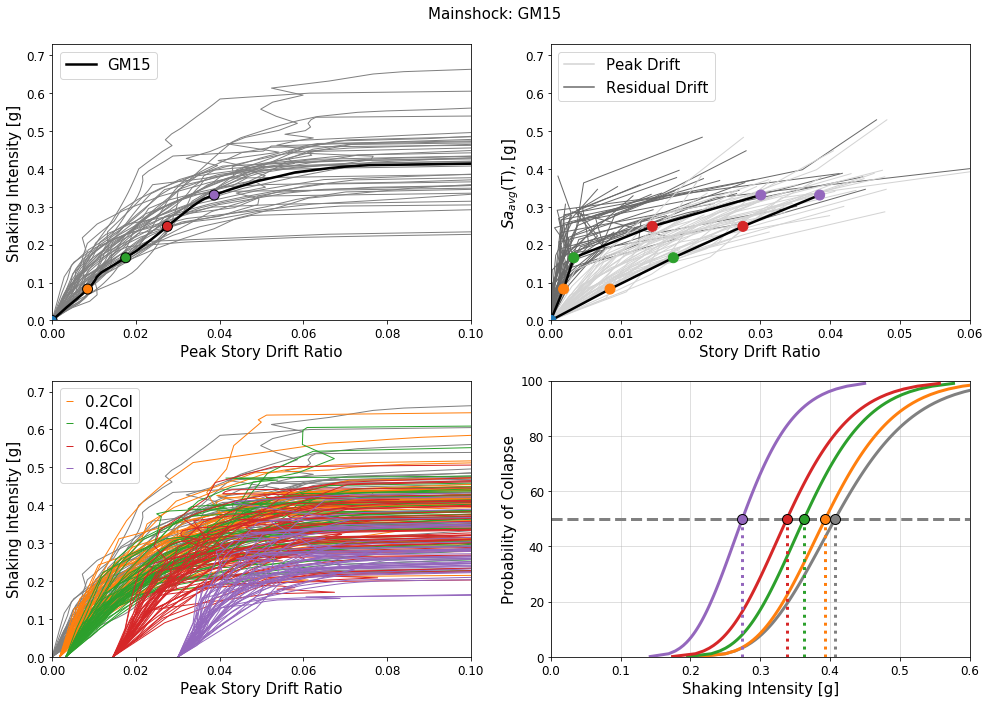

In [4]:
damaged_group = 'mainshock_damage_results'
fragility_linewidth = 3

DriftLimit = 0.1

with h5py.File(results_filename, 'r') as hf:
    ida_fragilities = ida_intact_fragility.copy()

    # To plot selected mainshock intensities
    stripes_total = list(hf[damaged_group][gm_id].keys())
    stripes = ['0.2Col', '0.4Col', '0.6Col', '0.8Col']
    index = [True] # intact
    for i, a_i in enumerate(stripes_total):
        if stripes.count(a_i) > 0:
            index.append(True)
        else:
            index.append(False)
    peak_segments = peak_segments[:, index, :]
    residual_segments = residual_segments[:, index, :]

    i = int(gm_id[2:]) - 1

    if len(stripes) > 1:
        fig, ax = plt.subplots(2, 2, figsize=(14, 10))
        suptitle = fig.suptitle('Mainshock: ' + gm_id)
        ax[0][0].get_shared_x_axes().join(ax[0][0], ax[1][0])
        ax[0][0].get_shared_y_axes().join(ax[0][0], ax[1][0])
        ax[0][0].get_shared_y_axes().join(ax[0][0], ax[0][1])

        # intact ida
        current_ax = ax[0][0]
        ida_ylim = [0, 1.1 * np.amax(intact_ida_segments[:, :, 1])]
        full_ida_plot = LineCollection(intact_ida_segments, linewidths=1, colors='gray', linestyle='solid')
        _ = current_ax.add_collection(full_ida_plot)
        _ = current_ax.set_xlim(0, DriftLimit)
        _ = current_ax.set_ylim(ida_ylim)
        _ = current_ax.set_ylabel('Shaking Intensity [g]')
        _ = current_ax.set_xlabel('Peak Story Drift Ratio')

        _ = current_ax.plot(intact_ida_segments[i, :, 0], intact_ida_segments[i, :, 1], color='k', linewidth=2.5,
                            label=gm_id)
        _ = current_ax.legend(loc='upper left')

        if True:
            current_ax = ax[1][0]
            full_ida_plot = LineCollection(intact_ida_segments, linewidths=1, colors='gray', linestyle='solid')
            _ = current_ax.add_collection(full_ida_plot)

        # mainshock responses
        current_ax = ax[0][1]
        residual_plot = LineCollection(residual_segments, linewidths=1, colors='dimgray', linestyle='solid')
        _ = current_ax.add_collection(residual_plot)
        peak_plot = LineCollection(peak_segments, linewidths=1, colors='lightgray', linestyle='solid')
        _ = current_ax.add_collection(peak_plot)
        _ = current_ax.plot(residual_segments[i, :, 0], residual_segments[i, :, 1], color='k', linewidth=2.5)
        _ = current_ax.plot(peak_segments[i, :, 0], peak_segments[i, :, 1], color='k', linewidth=2.5)
        legend_elements = [Line2D([0], [0], color='lightgray', label='Peak Drift'),
                           Line2D([0], [0], color='dimgray', label='Residual Drift')]
        _ = current_ax.legend(handles=legend_elements, loc='upper left')
        _ = current_ax.set_xlim(0, 0.06)

        s = 0
        # intact ida fragilities
        current_ax = ax[1][1]
        median = ida_fragilities.loc['Intact', 'Median']
        beta = ida_fragilities.loc['Intact', 'Beta']

        y = np.linspace(0.001, 1, num=100)
        x = stats.lognorm(beta, scale=median).ppf(y)
        label = 'No Mainshock' + '\n$IM_{0.5}=$' + '{0:.2f}'.format(median) + ' $\sigma_{ln}=$' + '{0:.2f}'.format(
            beta)
        _ = current_ax.plot(x, 100 * y, label=label, color='gray', linewidth=fragility_linewidth)
        _ = current_ax.plot([median, median], [0, 50], color='gray', linewidth=fragility_linewidth, linestyle='dotted')
        _ = current_ax.scatter(median, 50, color='gray', edgecolor='k', zorder=50, s=100)

        key = '/intact_results/ida/collapse_intensities'
        collapse_intensities = pd.read_hdf(results_filename, key)['Sa_avg'].to_numpy()
        n_gms = len(collapse_intensities)

        for stripe, s in zip(stripes, range(1, len(stripes) + 1)):

            # mainshock stripe ida fragilities
            current_ax = ax[1][1]
            key = damaged_group + '/' + gm_id + '/' + stripe + '/ida/collapse_fragilities'
            ida_fragilities.loc[stripe, :] = pd.read_hdf(results_filename, key).to_numpy()[1,
                                             :]  # 1 is for Sa_avg, 0 for Sa(T1)

            median = ida_fragilities.loc[stripe, 'Median']
            beta = ida_fragilities.loc[stripe, 'Beta']

            y = np.linspace(0.001, 1, num=100)
            x = stats.lognorm(beta, scale=median).ppf(y)
            label = 'Mainshock: ' + stripe + '\n$IM_{0.5}=$' + '{0:.2f}'.format(
                median) + ', $\sigma_{ln}=$' + '{0:.2f}'.format(beta)
            _ = current_ax.plot(x, 100 * y, label=label, color='C' + str(s), linewidth=fragility_linewidth)
            _ = current_ax.plot([median, median], [0, 50], color='C' + str(s), linewidth=fragility_linewidth, linestyle='dotted')

            # post-mainshock idas
            damaged_ida_folder = '/mainshock_damage_results/' + gm_id + '/' + stripe + '/ida/'
            damaged_ida_segments = collect_ida_curves(results_filename, gm_metadata, damaged_ida_folder)
            # adjust to include residual drift
            damaged_edp_folder = '/mainshock_damage_results/' + gm_id + '/' + stripe + '/mainshock_edp/'
            dset = damaged_edp_folder + 'residual_story_drift'
            residual_drift = hf[dset].attrs['max_residual_story_drift']
            damaged_ida_segments[:, 0, 0] = residual_drift
            
            # add reference points to fragilities
            current_ax = ax[1][1]
            _ = current_ax.scatter(median, 50, color='C' + str(s), edgecolor='k', zorder=50, s=100)

            if True:
                current_ax = ax[1][0]
                ida_plot = LineCollection(damaged_ida_segments, linewidths=1, colors='C' + str(s),
                                          linestyle='solid', label=stripe)
                _ = current_ax.add_collection(ida_plot)
                _ = current_ax.legend(loc='upper left', handlelength=0.5)

        current_ax = ax[1][1]
        _ = current_ax.set_xlim(0, 0.6)
        _ = current_ax.plot([0, 0.6], [50, 50], color='gray', linewidth=fragility_linewidth, linestyle='dashed')
        _ = current_ax.set_ylabel('Probability of Collapse')
        _ = current_ax.set_ylim(0, 100)
        _ = current_ax.set_xlabel('Shaking Intensity [g]')
        _ = current_ax.grid('on', alpha=0.5)

        current_ax = ax[1][0]
        _ = current_ax.set_xlim(0, DriftLimit)
        _ = current_ax.set_ylim(ida_ylim)
        _ = current_ax.set_ylabel('Shaking Intensity [g]')
        _ = current_ax.set_xlabel('Peak Story Drift Ratio')

        current_ax = ax[0][1]
        _ = current_ax.set_ylabel('$Sa_{avg}$(T), [g]')
        _ = current_ax.set_xlabel('Story Drift Ratio')

        # add reference points to ida
        current_ax = ax[0][0]
        sa_avg_col = gm_metadata.loc[gm_id, 'Intact Collapse Sa_avg']
        stripe_values = sa_avg_col * np.insert(np.array([float(x[:-3]) for x in stripes]), 0, 0)
        x = np.interp(stripe_values, intact_ida_segments[i, :, 1], intact_ida_segments[i, :, 0])  
        color = ['C' + str(k) for k in range(len(stripe_values))]
        _ = current_ax.scatter(x, stripe_values, color=color, edgecolors='k', zorder=50, s=100)
        
#         # Add collapse points to ida (intact fragility)
#         col_im = gm_metadata['Intact Collapse Sa_avg']
#         x = np.ones(len(col_im))*(DriftLimit*0.992)
#         _ = current_ax.scatter(x, col_im, color='tab:blue', zorder=50, s=20,
#                                edgecolors='k', linewidth=0.5)

        # add reference points to mainshocks
        current_ax = ax[0][1]
        y = peak_segments[i, :, 1]
        x = peak_segments[i, :, 0]
        _ = current_ax.scatter(x, y, color=color, zorder=50, s=100)
        x = residual_segments[i, :, 0]
        _ = current_ax.scatter(x, y, color=color, zorder=50, s=100)

        fig.tight_layout(rect=[0, 0, 1, 0.95])
        if savefig:
            figname = gm_id + '_Mainshocks.svg'
            plt.savefig(figname, dpi=300)
        plt.show()